# Forcing JSON with tool use

## Learning goals

* Understand using tools to force a structured response
* Utilize this "trick" to generate structured JSON

One of the more interesting ways of utilizing tool use is in forcing Claude to respond with structured content like JSON.  There are many situations in which we may want to get a standardized JSON response from Claude: extracting entities, summarizing data, analyzing sentiment, etc. 

One way of doing this is simply asking Claude to respond with JSON, but this can require additional work to actually extract the JSON from the big string we get back from Claude or to make sure the JSON follows the exact format we want.

The good news is that **whenever Claude wants to use a tool, it already responds using the perfectly structured format we told it to use when we defined the tool.**

In the previous lesson, we gave Claude a calculator tool.  When it wanted to use the tool, it responded with content like this: 

```
{
    'operand1': 1984135, 
    'operand2': 9343116, 
    'operation': 'multiply'
}
```

That looks suspiciously similar to JSON! 

If we want Claude to generate structured JSON, we can use this to our advantage.  All we have to do is define a tool that describes a particular JSON structure and then tell Claude about it.  That's it.  Claude will respond back, thinking it's "calling a tool" but really all we care about is the structured response it gives us.

***

# Conceptual overview

How is this different than what we did in the previous lesson?  Here's a diagram of the workflow from the last lesson: 

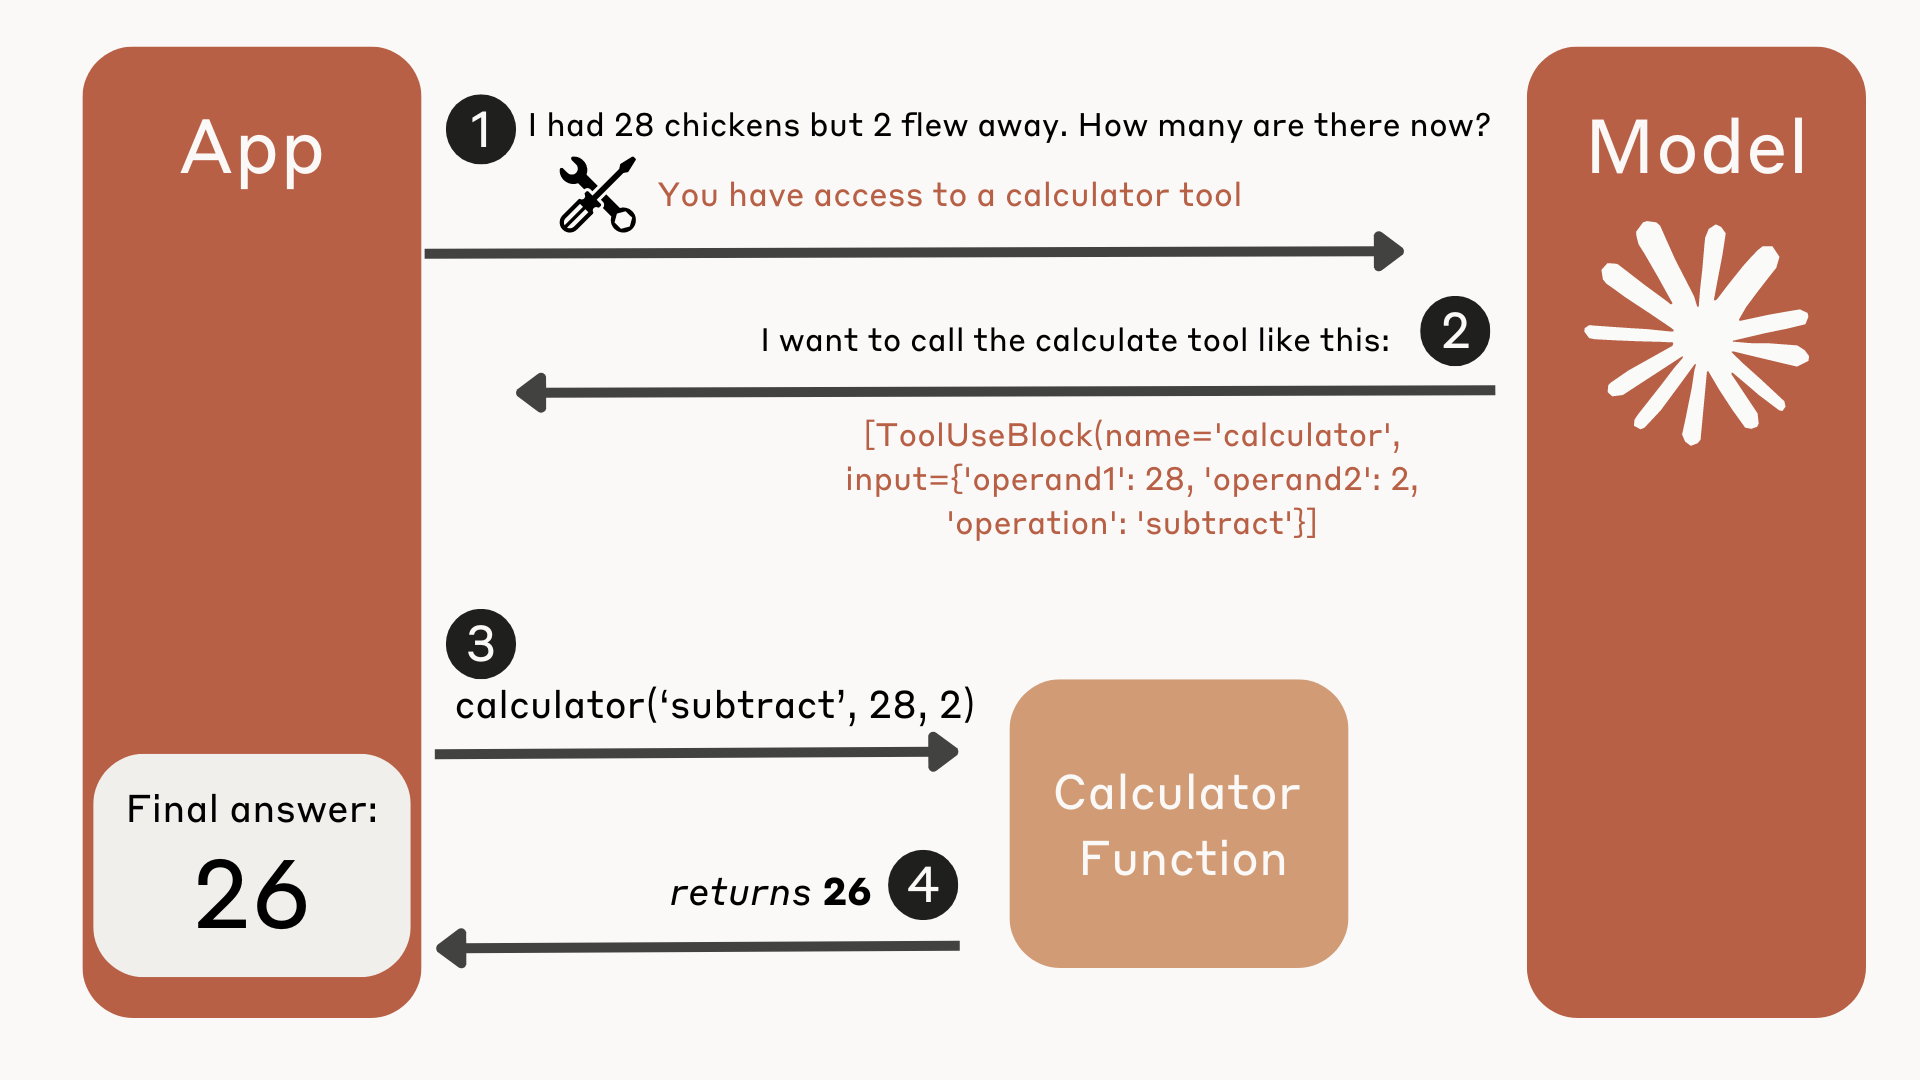

In the last lesson, we gave Claude access to a tool, Claude wanted to call it, and then we actually called the underlying tool function.

In this lesson, we're going to "trick" Claude by telling it about a particular tool, but we won't need to actually call the underlying tool function.  We're using the tool as a way of forcing a particular structure of response, as seen in this diagram:

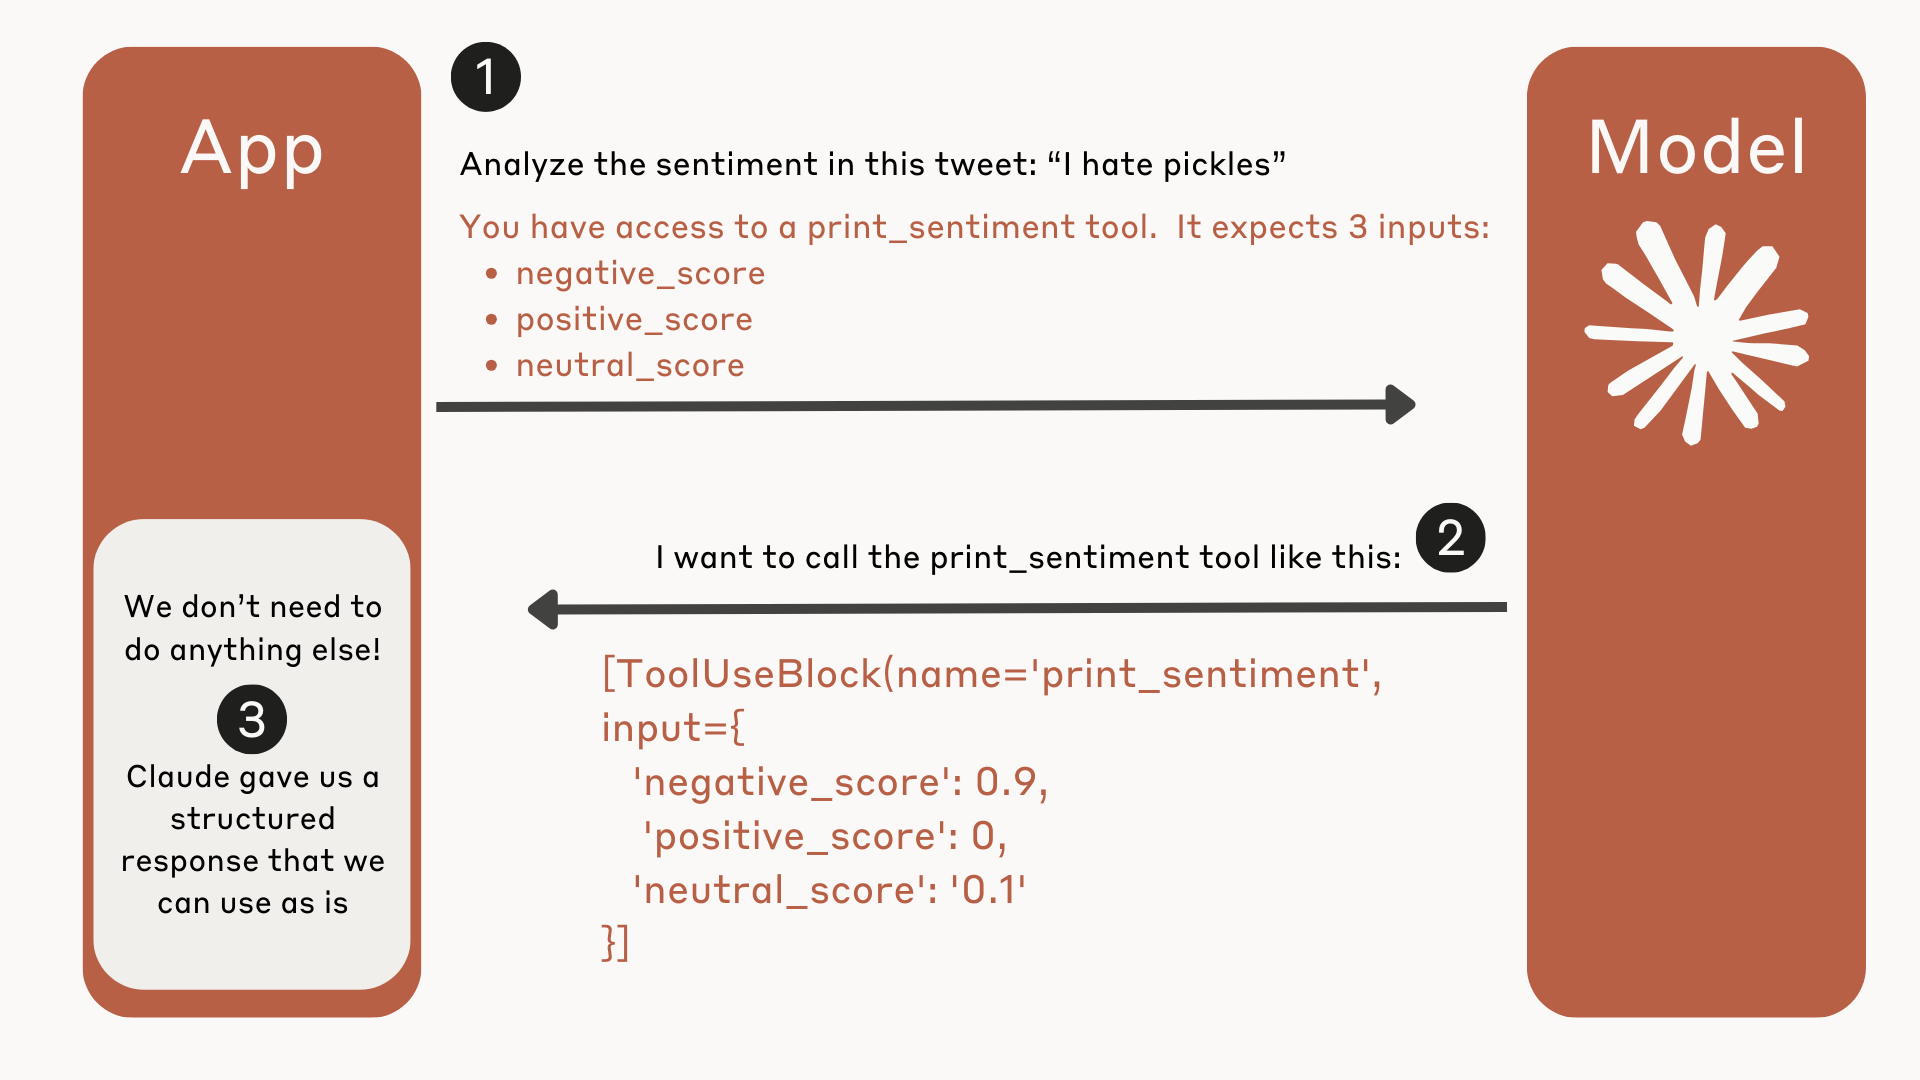

## Sentiment analysis
Let's start with a simple example.  Suppose we want Claude to analyze the sentiment in some text and respond with a JSON object that follows this shape: 

```
{
  "negative_score": 0.6,
  "neutral_score": 0.3,
  "positive_score": 0.1
}
```

All we have to do is define a tool that captures this shape using JSON Schema.  Here's a potential implementation: 

In [15]:
tools = [
    {
        "name": "print_sentiment_scores",
        "description": "Prints the sentiment scores of a given text.",
        "input_schema": {
            "type": "object",
            "properties": {
                "positive_score": {"type": "number", "description": "The positive sentiment score, ranging from 0.0 to 1.0."},
                "negative_score": {"type": "number", "description": "The negative sentiment score, ranging from 0.0 to 1.0."},
                "neutral_score": {"type": "number", "description": "The neutral sentiment score, ranging from 0.0 to 1.0."}
            },
            "required": ["positive_score", "negative_score", "neutral_score"]
        }
    }
]

Now we can tell Claude about this tool and explicitly tell Claude to use it, to ensure that it actually does use it.  We should get a response telling us that Claude wants to use a tool.  The tool use response should contain all the data in the exact format we want.

In [5]:
from anthropic import Anthropic
from dotenv import load_dotenv
import json

load_dotenv()
client = Anthropic()

tweet = "I'm a HUGE hater of pickles.  I actually despise pickles.  They are garbage."

query = f"""
<text>
{tweet}
</text>

Only use the print_sentiment_scores tool.
"""

response = client.messages.create(
    model="claude-3-sonnet-20240229",
    max_tokens=4096,
    tools=tools,
    messages=[{"role": "user", "content": query}]
)

In [6]:
response

ToolsBetaMessage(id='msg_01BhF4TkK8vDM6z5m4FNGRnB', content=[TextBlock(text='Here is the sentiment analysis for the given text:', type='text'), ToolUseBlock(id='toolu_01Mt1an3KHEz5RduZRUUuTWz', input={'positive_score': 0.0, 'negative_score': 0.791, 'neutral_score': 0.209}, name='print_sentiment_scores', type='tool_use')], model='claude-3-sonnet-20240229', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=374, output_tokens=112))

Let's take a look at the response we get back from Claude.  We've bolded the important part:


>ToolsBetaMessage(id='msg_01BhF4TkK8vDM6z5m4FNGRnB', content=[TextBlock(text='Here is the sentiment analysis for the given text:', >type='text'), ToolUseBlock(id='toolu_01Mt1an3KHEz5RduZRUUuTWz', **input={'positive_score': 0.0, 'negative_score': 0.791, 'neutral_score': 0.209}**, name='print_sentiment_scores', type='tool_use')], model='claude-3-sonnet-20240229', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=374, output_tokens=112))

Claude "thinks" it's calling a tool that will use this sentiment analysis data, but really we're just going to extract the data and turn it into JSON:

In [9]:
import json
json_sentiment = None
for content in response.content:
    if content.type == "tool_use" and content.name == "print_sentiment_scores":
        json_sentiment = content.input
        break

if json_sentiment:
    print("Sentiment Analysis (JSON):")
    print(json.dumps(json_sentiment, indent=2))
else:
    print("No sentiment analysis found in the response.")

Sentiment Analysis (JSON):
{
  "positive_score": 0.0,
  "negative_score": 0.791,
  "neutral_score": 0.209
}


It works! Now let's turn that into a reusable function that takes a tweet or article and then prints or returns the sentiment analysis as JSON.

In [ ]:
def analyze_sentiment(content):

    query = f"""
    <text>
    {content}
    </text>

    Only use the print_sentiment_scores tool.
    """

    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        max_tokens=4096,
        tools=tools,
        messages=[{"role": "user", "content": query}]
    )

    json_sentiment = None
    for content in response.content:
        if content.type == "tool_use" and content.name == "print_sentiment_scores":
            json_sentiment = content.input
            break

    if json_sentiment:
        print("Sentiment Analysis (JSON):")
        print(json.dumps(json_sentiment, indent=2))
    else:
        print("No sentiment analysis found in the response.")


In [11]:
analyze_sentiment("OMG I absolutely love taking bubble baths soooo much!!!!")

Sentiment Analysis (JSON):
{
  "positive_score": 0.8,
  "negative_score": 0.0,
  "neutral_score": 0.2
}


In [12]:
analyze_sentiment("Honestly I have no opinion on taking baths")

Sentiment Analysis (JSON):
{
  "positive_score": 0.056,
  "negative_score": 0.065,
  "neutral_score": 0.879
}


***

## Forcing tool use with `tool_choice` 

Currently we're "forcing" Claude to use our `print_sentiment_scores` tool through prompting.  In our prompt, we write `Only use the print_sentiment_scores tool.` which usually works, but there's a better way! We can actually force Claude to use a specific tool using the `tool_choice` parameter:

In [ ]:
tool_choice={"type": "tool", "name": "print_sentiment_scores"}

The above code tells Claude that it must respond by calling the `print_sentiment_scores` tool.  Let's update our function to use it:

In [ ]:
def analyze_sentiment(content):

    query = f"""
    <text>
    {content}
    </text>

    Only use the print_sentiment_scores tool.
    """

    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        max_tokens=4096,
        tools=tools,
        tool_choice={"type": "tool", "name": "print_sentiment_scores"},
        messages=[{"role": "user", "content": query}]
    )

    json_sentiment = None
    for content in response.content:
        if content.type == "tool_use" and content.name == "print_sentiment_scores":
            json_sentiment = content.input
            break

    if json_sentiment:
        print("Sentiment Analysis (JSON):")
        print(json.dumps(json_sentiment, indent=2))
    else:
        print("No sentiment analysis found in the response.")

We'll cover `tool_choice` in greater detail in an upcoming lesson.

***

## Entity extraction example

Let's use this same approach to get Claude to generate nicely formatted JSON that contains entities like people, organizations, and locations extracted from a text sample:


In [14]:
tools = [
    {
        "name": "print_entities",
        "description": "Prints extract named entities.",
        "input_schema": {
            "type": "object",
            "properties": {
                "entities": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "The extracted entity name."},
                            "type": {"type": "string", "description": "The entity type (e.g., PERSON, ORGANIZATION, LOCATION)."},
                            "context": {"type": "string", "description": "The context in which the entity appears in the text."}
                        },
                        "required": ["name", "type", "context"]
                    }
                }
            },
            "required": ["entities"]
        }
    }
]

text = "John works at Google in New York. He met with Sarah, the CEO of Acme Inc., last week in San Francisco."

query = f"""
<document>
{text}
</document>

Use the print_entities tool.
"""

response = client.messages.create(
    model="claude-3-sonnet-20240229",
    max_tokens=4096,
    tools=tools,
    messages=[{"role": "user", "content": query}]
)

json_entities = None
for content in response.content:
    if content.type == "tool_use" and content.name == "print_entities":
        json_entities = content.input
        break

if json_entities:
    print("Extracted Entities (JSON):")
    print(json.dumps(json_entities, indent=2))
else:
    print("No entities found in the response.")

Extracted Entities (JSON):
{
  "entities": [
    {
      "name": "John",
      "type": "PERSON",
      "context": "John works at Google in New York."
    },
    {
      "name": "Google",
      "type": "ORGANIZATION",
      "context": "John works at Google in New York."
    },
    {
      "name": "New York",
      "type": "LOCATION",
      "context": "John works at Google in New York."
    },
    {
      "name": "Sarah",
      "type": "PERSON",
      "context": "He met with Sarah, the CEO of Acme Inc., last week in San Francisco."
    },
    {
      "name": "Acme Inc.",
      "type": "ORGANIZATION",
      "context": "He met with Sarah, the CEO of Acme Inc., last week in San Francisco."
    },
    {
      "name": "San Francisco",
      "type": "LOCATION",
      "context": "He met with Sarah, the CEO of Acme Inc., last week in San Francisco."
    }
  ]
}


We're using the same "trick" as before.  We tell Claude it has access to a tool as a way of getting Claude to respond with a particular data format.  Then we extract the formatted data Claude responded with, and we're good to go. 

Remember that in this use case, it helps to explicitly tell Claude we want it to use a given tool:


>Use the print_entities tool.


***

## Wikipedia summary example with more complex data

Let's try another example that's a little more complex.  We'll use the Python `wikipedia` package to get entire Wikipedia page articles and pass them to Claude.  We'll use Claude to generate a response that includes:

* The main subject of the article
* A summary of the article
* A list of keywords and topics mentioned in the article
* A list of category classifications for the article (entertainment, politics, business, etc.) along with a classification score (i.e., how strongly the topic falls into that category)

If we passed Claude the Wikipedia article about Walt Disney, we might expect a result like this: 

```
{
  "subject": "Walt Disney",
  "summary": "Walter Elias Disney was an American animator, film producer, and entrepreneur. He was a pioneer of the American animation industry and introduced several developments in the production of cartoons. He held the record for most Academy Awards earned and nominations by an individual. He was also involved in the development of Disneyland and other theme parks, as well as television programs.",
  "keywords": [
    "Walt Disney",
    "animation",
    "film producer",
    "entrepreneur",
    "Disneyland",
    "theme parks",
    "television"
  ],
  "categories": [
    {
      "name": "Entertainment",
      "score": 0.9
    },
    {
      "name": "Business",
      "score": 0.7
    },
    {
      "name": "Technology",
      "score": 0.6
    }
  ]
}
```

Here's an example implementation of a function that expects a Wikipedia page subject, finds the article, downloads the contents, passes it to Claude, and then prints out the resulting JSON data.  We use the same strategy of defining a tool to "coach" the shape of Claude's response.

Note: make sure to `pip install wikipedia` if you don't have it on your machine!

In [27]:
import wikipedia

#tool definition
tools = [
    {
        "name": "print_article_classification",
        "description": "Prints the classification results.",
        "input_schema": {
            "type": "object",
            "properties": {
                "subject": {
                    "type": "string",
                    "description": "The overall subject of the article",
                },
                "summary": {
                    "type": "string",
                    "description": "A paragaph summary of the article"
                },
                "keywords": {
                    "type": "array",
                    "items": {
                        "type": "string",
                        "description": "List of keywords and topics in the article"
                    }
                },
                "categories": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "The category name."},
                            "score": {"type": "number", "description": "The classification score for the category, ranging from 0.0 to 1.0."}
                        },
                        "required": ["name", "score"]
                    }
                }
            },
            "required": ["subject","summary", "keywords", "categories"]
        }
    }
]

#The function that generates the json for a given article subject
def generate_json_for_article(subject):
    page = wikipedia.page(subject, auto_suggest=True)
    query = f"""
    <document>
    {page.content}
    </document>

    Use the print_article_classification tool. Example categories are Politics, Sports, Technology, Entertainment, Business.
    """

    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=4096,
        tools=tools,
        messages=[{"role": "user", "content": query}]
    )

    json_classification = None
    for content in response.content:
        if content.type == "tool_use" and content.name == "print_article_classification":
            json_classification = content.input
            break

    if json_classification:
        print("Text Classification (JSON):")
        print(json.dumps(json_classification, indent=2))
    else:
        print("No text classification found in the response.")

In [29]:
generate_json_for_article("Jeff Goldblum")

Text Classification (JSON):
{
  "subject": "Jeff Goldblum",
  "summary": "Jeffrey Lynn Goldblum is an American actor and musician who has starred in some of the highest-grossing films, such as Jurassic Park and Independence Day. He has had a long and successful career in both film and television, with roles in a wide range of movies and TV shows. Goldblum is also an accomplished jazz musician and has released several albums with his band, The Mildred Snitzer Orchestra.",
  "keywords": [
    "actor",
    "musician",
    "Jurassic Park",
    "Independence Day",
    "film",
    "television",
    "jazz"
  ],
  "categories": [
    {
      "name": "Entertainment",
      "score": 0.9
    }
  ]
}


In [37]:
generate_json_for_article("Octopus")

Text Classification (JSON):
{
  "subject": "Octopus",
  "summary": "This article provides a comprehensive overview of octopuses, including their anatomy, physiology, behavior, ecology, and evolutionary history. It covers topics such as their complex nervous systems, camouflage and color-changing abilities, intelligence, and relationships with humans.",
  "keywords": [
    "octopus",
    "cephalopod",
    "mollusc",
    "marine biology",
    "animal behavior",
    "evolution"
  ],
  "categories": [
    {
      "name": "Science",
      "score": 0.9
    },
    {
      "name": "Nature",
      "score": 0.8
    }
  ]
}


In [38]:
generate_json_for_article("Herbert Hoover")

Text Classification (JSON):
{
  "subject": "Herbert Hoover",
  "summary": "The article provides a comprehensive biography of Herbert Hoover, the 31st President of the United States. It covers his early life, career as a mining engineer and humanitarian, his presidency during the Great Depression, and his post-presidency activities.",
  "keywords": [
    "Herbert Hoover",
    "Great Depression",
    "Republican Party",
    "U.S. President",
    "mining engineer",
    "Commission for Relief in Belgium",
    "U.S. Food Administration",
    "Secretary of Commerce",
    "Smoot\u2013Hawley Tariff Act",
    "New Deal"
  ],
  "categories": [
    {
      "name": "Politics",
      "score": 0.9
    },
    {
      "name": "Business",
      "score": 0.7
    },
    {
      "name": "History",
      "score": 0.8
    }
  ]
}


***

## Exercise

Use the above strategy to write a function called `translate` that takes a word or phrase and generates a structured JSON output that includes the original phrase in English and the translated phrase in Spanish, French, Japanese, and Arabic.

Here is an example of how this should work:

If we call this:

In [ ]:
translate("how much does this cost")

We expect an output like this: 

```json
{
  "english": "how much does this cost",
  "spanish": "¿cuánto cuesta esto?",
  "french": "combien ça coûte?",
  "japanese": "これはいくらですか",
  "arabic": "كم تكلفة هذا؟"
}
```

**NOTE: If you want to print your results, this line of code will help you print them out nicely:**

In [ ]:
print(json.dumps(translations_from_claude, ensure_ascii=False, indent=2))